In [1]:
#[Joe] 1. Acquire and process stock data
#[Alejandra]x 2. Acquire and process sentiment analysis data
#[Session] 3. Run baseline
#[Joe]x 4. Run sentiment analysis with LinearDiscreminateAnalysis
#[Edward] 5. Run sentiment analysis with alternate classifier
#[Edward] 6. Combine results
#[Session] 7. Put together PPT preso

In [2]:
import pandas as pd
from pathlib import Path
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import svm
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

# Ignore all warnings within this code block
warnings.filterwarnings("ignore")

In [3]:
### Acquire and process data

## Acquire and process stock data
combined_df = pd.read_csv(Path("Resources/combined_csv.csv"), index_col = 'Time', infer_datetime_format = True, parse_dates = True)

# Add a column for the daily stock returns
combined_df['Actual Returns'] = combined_df['TSLA Close'].pct_change()

# create dataframe for stock close data from yfinance (csv files)

# drop all columns other than 'Date', 'Close', and 'Volume'

# adjust the Date datetime format

# set the Date column as index

# create a column for returns


In [4]:
## Acquire and process sentiment data from Kaggle

# create a dataframe that concatenate all of the headline files

# clean the sentiment dataframe

# obtain polarity and subjectivity scores (potentially factor volume of information in the sentiment analysis)


,TSLA Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Time,,,,,,
2018-03-19,20.903999,-0.024241,21.920571,22.285689,-1.0,NaN
2018-03-20,20.703333,-0.009599,21.762286,22.254222,-1.0,0.009599
2018-03-21,21.101999,0.019256,21.486285,22.238033,1.0,-0.019256
2018-03-22,20.606667,-0.023473,21.174476,22.215944,-1.0,-0.023473
2018-03-23,20.102667,-0.024458,20.935523,22.182478,-1.0,0.024458


,TSLA Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Time,,,,,,
2020-07-13,99.804001,-0.030810,93.066382,61.753511,-1.0,-0.030810
2020-07-14,101.120003,0.013186,96.001050,62.601189,1.0,-0.013186
2020-07-15,103.067329,0.019258,97.662287,63.489689,1.0,0.019258
2020-07-16,100.042664,-0.029347,98.717334,64.394044,-1.0,-0.029347
2020-07-17,100.056000,0.000133,100.002667,65.248189,1.0,-0.000133


 1.0    303
-1.0    285
Name: Signal, dtype: int64

<Axes: xlabel='Time'>

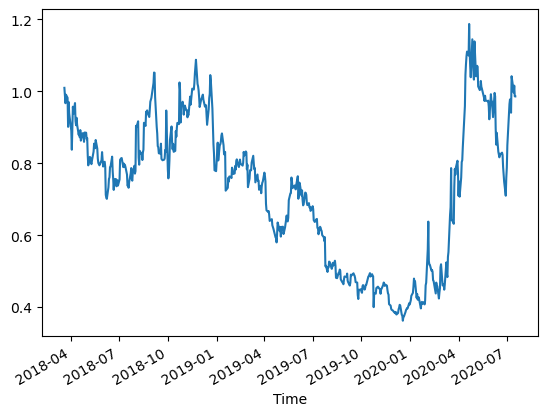

In [5]:
### Run baseline prediction with moving average windows

## Generate trading signals using short- and long-window SMA values

# Set the short window and long window
short_window = 7
long_window = 60

# Create a signals data frame that copies from combined_df
signals_df = combined_df[['TSLA Close', 'Actual Returns']].copy()

# Generate the fast and slow simple moving averages
signals_df['SMA_Fast'] = signals_df['TSLA Close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['TSLA Close'].rolling(window=long_window).mean()

# Remove any nulls
signals_df = signals_df.dropna()

# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

# Review the split of the signals
display(signals_df['Signal'].value_counts())

# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [6]:
## Split the data into training and testing datasets

# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Select the start of the training period
training_begin = X.index.min()

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_train DataFrame
display(X_train.head())

# Review the X_test DataFrame
display(X_test.head())

,SMA_Fast,SMA_Slow
Time,,
2018-03-20,21.920571,22.285689
2018-03-21,21.762286,22.254222
2018-03-22,21.486285,22.238033
2018-03-23,21.174476,22.215944
2018-03-26,20.935523,22.182478


,SMA_Fast,SMA_Slow
Time,,
2018-06-21,23.705143,19.910167
2018-06-22,23.750286,19.986089
2018-06-25,23.644095,20.070367
2018-06-26,23.408762,20.144678
2018-06-27,23.254762,20.244144


In [7]:
## Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [8]:
## Use a classifier to predict future results

# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Use a classification report to evaluate the model using the predictions and testing data
print(classification_report(y_test, svm_pred))

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

              precision    recall  f1-score   support

        -1.0       0.55      0.21      0.31       254
         1.0       0.53      0.84      0.65       268

    accuracy                           0.53       522
   macro avg       0.54      0.52      0.48       522
weighted avg       0.54      0.53      0.48       522



,Predicted,Actual Returns,Strategy Returns
Time,,,
2018-06-21,1.0,-0.040611,NaN
2018-06-22,1.0,-0.039941,-0.039941
2018-06-25,1.0,-0.001858,-0.001858
2018-06-26,1.0,0.026996,0.026996
2018-06-27,1.0,0.007310,0.007310


,Predicted,Actual Returns,Strategy Returns
Time,,,
2020-07-13,1.0,-0.030810,-0.030810
2020-07-14,1.0,0.013186,0.013186
2020-07-15,1.0,0.019258,0.019258
2020-07-16,1.0,-0.029347,-0.029347
2020-07-17,1.0,0.000133,0.000133


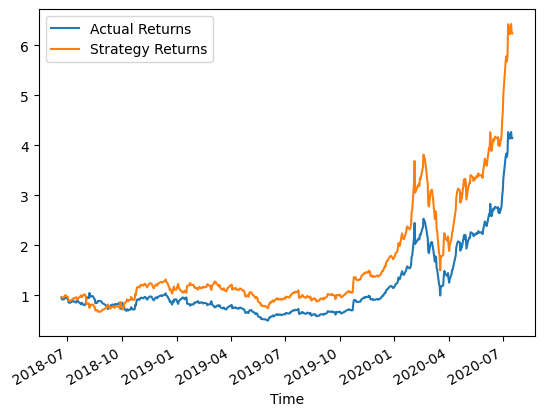

In [9]:
## Plot cummulative returns for the baseline model

# Plot the actual returns versus the strategy returns
baseline_plot = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod()
baseline_plot.plot()

# Save the baseline plot to a file
plt.savefig(Path('Resources/Baseline.png'), format='png', dpi=300)

In [10]:
### Run LinearDiscreminateAnalysis to create predictions with sentiment analysis
lda_model = LinearDiscriminantAnalysis()

# Fit the model to the data using the training data
linear_disc_model = lda_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
linear_disc_model = lda_model.predict(X_test_scaled)

# Review the model's predicted values
linear_disc_model[:10]

# Use a classification report to evaluate the model using the predictions and testing data
linear_disc_testing_report = classification_report(y_test, linear_disc_model)

predictions_sentiment_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_sentiment_df['Predicted'] = linear_disc_model

# Add the actual returns to the DataFrame
predictions_sentiment_df['Actual Returns'] = sentiment_df['daily returns'].pct_change()

# Add the strategy returns to the DataFrame
predictions_sentiment_df['Strategy Returns'] = predictions_sentiment_df['Actual Returns'] * predictions_sentiment_df['Predicted']

# Save the baseline plot to a file
lda_baseline_plot = predictions_sentiment_3_df.plot(title='LDA Model - Baseline')
plt.savefig(Path('../Resources/Alt_Model_LDA.png'), format='png', dpi=300)

In [11]:
# Print the classification report
print(linear_disc_testing_report)

In [ ]:
### Alejandra to add SVC with sentiment


In [12]:
### Evaluate results

## Combine the plots of the baseline and the ML models using sentiment analysis

## Display the various classification reports
